# 3D analysis of GRB 190829A: A low level interface
### Introduction:

- Understanding the gammapy data workflow is the first step, in particular what are DL3 events and intrument response functions (IRF).

- Understanding of how the data reduction and modeling fitting process is done.

- In this notebook, we used an introduction to gammapy analysis notebook provided in the gammapy website [here](https://docs.gammapy.org/0.17/notebooks/analysis_2.html).
- We used the lower level classes and functions the library. This allows to understand what happens during two main gammapy analysis steps, data reduction and modeling/fitting.

### Objective: 
- Create a 3D dataset of the GRB using the H.E.S.S. DL3 data observed in the first night of the burst and perform a simple model fitting of the Crab nebula using the lower level gammapy API.
### Methods:
- we have to interact with the data archive (with the gammapy.data.DataStore) to retrieve a list of selected observations (gammapy.data.Observations). 
- Then, we define the geometry of the gammapy.datasets.MapDataset object we want to produce and the maker object that reduce an observation to a dataset.
- We can then proceed with data reduction with a loop over all selected observations to produce datasets in the relevant geometry and stack them together (i.e. sum them all).

- In practice, we have to: 
    - Create a gammapy.data.DataStore poiting to the relevant data 
    - Apply an observation selection to produce a list of observations, a gammapy.data.Observations object. 
    - Define a geometry of the Map we want to produce, with a sky projection and an energy range. 
    - Create a gammapy.maps.MapAxis for the energy 
    - Create a gammapy.maps.WcsGeom for the geometry 
    - Create the necessary makers : 
        - The map dataset maker : gammapy.makers.MapDatasetMaker. 
        - The background normalization maker, here a gammapy.makers.FoVBackgroundMaker. 
        - And usually the safe range maker : gammapy.makers.SafeRangeMaker 
        - Perform the data reduction loop. 
    - And for every observation: 
        - Apply the makers sequentially to produce the current gammapy.datasets.MapDataset 
        - Stack it on the target one. - Define the gammapy.modeling.models.SkyModel to apply to the dataset. 
        - Create a gammapy.modeling.Fit object and run it to fit the model parameters 
        - Apply a gammapy.estimators.FluxPointsEstimator to compute flux points for the spectral part of the fit.

### Setup:
- First, we setup the analysis by performing required imports.

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt

In [2]:
from pathlib import Path
from astropy import units as u
from gammapy.analysis import Analysis, AnalysisConfig
from gammapy.modeling.models import create_crab_spectral_model

In [3]:
import warnings
warnings.filterwarnings('ignore')

In [4]:
config = AnalysisConfig()
# the AnalysisConfig gives access to the various parameters used from logging to reduced dataset geometries
#print(config)

In [5]:
# We define the datastore containing the data
config.observations.datastore = "$GAMMAPY_DATA/std_ImPACT_fullEnclosure"

# We define the cone search parameters
config.observations.obs_cone.frame = "icrs"
config.observations.obs_cone.lon = "44.544 deg"
config.observations.obs_cone.lat = "-8.958 deg"
config.observations.obs_cone.radius = "2.5 deg"

# Equivalently we could have set parameters with a python dict
# config.observations.obs_cone = {"frame": "icrs", "lon": "83.633 deg", "lat": "22.014 deg", "radius": "5 deg"}

In [6]:
run_list = 'night1'
runs_night1 = [152900, 152901, 152902, 152903, 152904, 152905, 152906, 152907]
runs_night2 = [152960, 152961, 152962, 152963, 152965, 152966, 152967, 152968, 152969, 152970]
runs_night3 = [153040, 153041, 153042, 153043, 153044, 153047, 153048, 153049, 153050] # 153045 (too short)

if run_list == 'night1':
    runs = runs_night1
    
elif run_list == 'night2':
    runs = runs_night2
    
elif run_list == 'night3':
    runs = runs_night3
    
elif run_list == 'all':
    runs = runs_night1 + runs_night2 +runs_night3

In [7]:
config.observations.obs_ids = runs

In [8]:
# We want to perform a 3D analysis
config.datasets.type = "3d"
# We want to stack the data into a single reduced dataset
config.datasets.stack = False

# We fix the WCS geometry of the datasets
config.datasets.geom.wcs.skydir = {
    "lon": "44.544 deg",
    "lat": "-8.958 deg",
    "frame": "icrs",
}
config.datasets.geom.wcs.fov = {"width": "4 deg", "height": "4 deg"}
config.datasets.geom.wcs.binsize = "0.02 deg"

# We now fix the energy axis for the counts map
config.datasets.geom.axes.energy.min = "0.1 TeV"
config.datasets.geom.axes.energy.max = "30 TeV"
config.datasets.geom.axes.energy.nbins = 48

# We now fix the energy axis for the IRF maps (exposure, etc)
config.datasets.geom.axes.energy_true.min = "0.05 TeV"
config.datasets.geom.axes.energy_true.max = "30 TeV"
config.datasets.geom.axes.energy.nbins = 48

In [9]:
config.datasets.background.method = "fov_background"
config.datasets.background.parameters = {"method": "scale"}

config.datasets.safe_mask.methods = ["aeff-default", "edisp-bias", "offset-max"]  
config.datasets.safe_mask.parameters = {'bias_percent':10, 'offset_max': 2.5*u.deg}

In [10]:
config.fit.fit_range.min = 0.1 * u.TeV
config.fit.fit_range.max = 5 * u.TeV
config.flux_points.energy = {"min": "0.18 TeV", "max": "3.3 TeV", "nbins": 10}

In [11]:
path = Path("../Data/3d_analysis_high_level_joint")
path.mkdir(exist_ok=True)

config.write(path/"config_3d_analysis_joint.yaml", overwrite=True)


In [12]:
analysis = Analysis(config)

Setting logging config: {'level': 'INFO', 'filename': None, 'filemode': None, 'format': None, 'datefmt': None}


In [13]:
analysis.get_observations()

Fetching observations.
Number of selected observations: 8


In [14]:
analysis.observations.ids

['152900',
 '152901',
 '152902',
 '152903',
 '152904',
 '152905',
 '152906',
 '152907']

In [15]:
%%time
joint_datasets = analysis.get_datasets()

Creating geometry.
Creating datasets.
Processing observation 152900
Processing observation 152901
Processing observation 152902
Processing observation 152903
Processing observation 152904
Processing observation 152905
Processing observation 152906
Processing observation 152907


CPU times: user 13 s, sys: 3.23 s, total: 16.2 s
Wall time: 16.5 s


In [16]:
analysis.datasets.parameters['tilt'].frozen = False

In [17]:
print(analysis.datasets[0])

MapDataset
----------

  Name                            : LGPDlkbW 

  Total counts                    : 2552 
  Total predicted counts          : 9539213334896.99
  Total background counts         : 9539213334896.99

  Exposure min                    : 0.00e+00 m2 s
  Exposure max                    : 9.28e+08 m2 s

  Number of total bins            : 1920000 
  Number of fit bins              : 1365596 

  Fit statistic type              : cash
  Fit statistic value (-2 log(L)) : 29819.94

  Number of models                : 1 
  Number of parameters            : 3
  Number of free parameters       : 2

  Component 0: BackgroundModel
  
    Name                      : LGPDlkbW-bkg
    Datasets names            : ['LGPDlkbW']
    Parameters:
      norm                    :   0.889              
      tilt                    :   0.000              
      reference    (frozen)   :   1.000  TeV         
  
  


In [18]:
print(analysis.datasets)

Datasets
--------
idx=0, id='0x7f8dd40df9b0', name='LGPDlkbW'
idx=1, id='0x7f8dd35fbcf8', name='vgEdDD45'
idx=2, id='0x7f8dd3618da0', name='0KTwoKaN'
idx=3, id='0x7f8dd35f7780', name='za03S6Ew'
idx=4, id='0x7f8dc5374240', name='vM7VyTxL'
idx=5, id='0x7f8dc54766a0', name='mQxw__Rx'
idx=6, id='0x7f8dc535d630', name='Vk6ryrrI'
idx=7, id='0x7f8dc54744e0', name='ZTlSG0lF'



In [19]:
for obs, dataset in zip(analysis.observations.ids, analysis.datasets):
    filename = path / f"grb190829a-3d_joint_{obs}_dataset.fits.gz"
    dataset.write(filename, overwrite=True)

In [20]:
ls ../Data/3d_analysis_high_level_joint/

Joint_3dmodel-best-fit.yaml
Joint_3dmodel-best-fit_covariance.dat
config_3d_analysis_joint.yaml
grb190829a-3d_joint_152900_dataset.fits.gz
grb190829a-3d_joint_152901_dataset.fits.gz
grb190829a-3d_joint_152902_dataset.fits.gz
grb190829a-3d_joint_152903_dataset.fits.gz
grb190829a-3d_joint_152904_dataset.fits.gz
grb190829a-3d_joint_152905_dataset.fits.gz
grb190829a-3d_joint_152906_dataset.fits.gz
grb190829a-3d_joint_152907_dataset.fits.gz


In [21]:
model_config = """
components:
- name: grb190829a
  type: SkyModel
  spatial:
    type: PointSpatialModel
    frame: icrs
    parameters:
    - name: lon_0
      value: 44.544
      unit: deg
    - name: lat_0
      value: -8.958
      unit: deg
  spectral:
    type: PowerLawSpectralModel
    parameters:
    - name: amplitude
      value: 1.0e-12
      unit: cm-2 s-1 TeV-1
    - name: index
      value: 2.0
      unit: ''
    - name: reference
      value: 0.556
      unit: TeV
      frozen: true
"""

In [22]:
analysis.set_models(model_config)

Reading model.
Models

Component 0: SkyModel

  Name                      : grb190829a
  Datasets names            : None
  Spectral model type       : PowerLawSpectralModel
  Spatial  model type       : PointSpatialModel
  Temporal model type       : None
  Parameters:
    index                   :   2.000              
    amplitude               :   1.00e-12  1 / (cm2 s TeV)
    reference    (frozen)   :   0.556  TeV         
    lon_0                   :  44.544  deg         
    lat_0                   :  -8.958  deg         




In [23]:
%%time
analysis.run_fit()

Fitting datasets.
OptimizeResult

	backend    : minuit
	method     : minuit
	success    : True
	message    : Optimization terminated successfully.
	nfev       : 569
	total stat : 259371.55



CPU times: user 5min, sys: 49 s, total: 5min 49s
Wall time: 5min 50s


In [24]:
print(analysis.fit_result)

OptimizeResult

	backend    : minuit
	method     : minuit
	success    : True
	message    : Optimization terminated successfully.
	nfev       : 569
	total stat : 259371.55



In [25]:
filename = path / "Joint_3dmodel-best-fit.yaml"
analysis.models.write(filename, overwrite=True)

In [26]:
!cat ../Data/3d_analysis_high_level_joint/Joint_3dmodel-best-fit.yaml

components:
-   name: grb190829a
    type: SkyModel
    spectral:
        type: PowerLawSpectralModel
        parameters:
        - {name: index, value: 2.4771044325010516, unit: '', min: .nan, max: .nan,
            frozen: false, error: 0.08903127803287775}
        - {name: amplitude, value: 1.4541891719963783e-11, unit: cm-2 s-1 TeV-1, min: .nan,
            max: .nan, frozen: false, error: 9.702855298815785e-13}
        - {name: reference, value: 0.556, unit: TeV, min: .nan, max: .nan, frozen: true,
            error: 0.0}
    spatial:
        type: PointSpatialModel
        frame: icrs
        parameters:
        - {name: lon_0, value: 44.54601726903122, unit: deg, min: .nan, max: .nan,
            frozen: false, error: 0.002848325105824728}
        - {name: lat_0, value: -8.962168305615464, unit: deg, min: .nan, max: .nan,
            frozen: false, error: 0.002913563020661938}
covariance: ../Data/3d_analysis_high_level_joint/Joint_3dmodel-best-fit_covariance.dat


In [27]:
%%time
analysis.config.flux_points.source = "grb190829a"
analysis.get_flux_points()

Calculating flux points.

       e_ref               ref_flux        ...        dnde_err        is_ul
        TeV              1 / (cm2 s)       ...    1 / (cm2 s TeV)          
------------------- ---------------------- ... ---------------------- -----
0.20400469235504903  8.492929591612208e-12 ...  2.926080156077964e-11 False
0.27457240569971814  8.267149679225821e-12 ... 1.1784827004854154e-11 False
 0.3695503525013146  3.531141737959515e-12 ...  8.137881960814376e-12 False
 0.4973823304851719 3.4372682560684362e-12 ... 3.4895627706250013e-12 False
 0.6694329500821696 1.4681579352635123e-12 ... 2.0398990238478324e-12 False
 0.9009979791975679 1.4291277553453145e-12 ...   9.88780697579038e-13 False
 1.2126641785685282  6.104223174351453e-13 ...  5.030134692180956e-13 False
 1.6321395207711393  5.941945722428002e-13 ... 2.3720707191224073e-13 False
 2.1967165043232177 2.5379790325896644e-13 ... 1.4518019408610132e-13 False
 2.7860403281929247 1.7866154302324956e-13 ...  1.131656605394

CPU times: user 4min 39s, sys: 55 s, total: 5min 34s
Wall time: 10min 45s


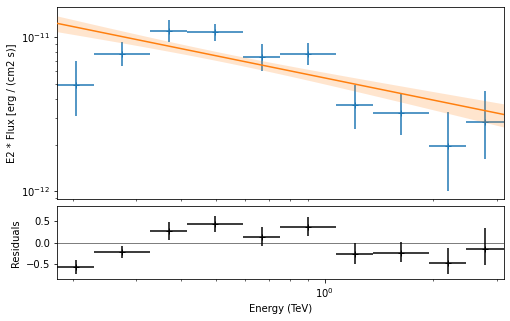

In [28]:
plt.figure(figsize=(8, 5))
ax_sed, ax_residuals = analysis.flux_points.peek()

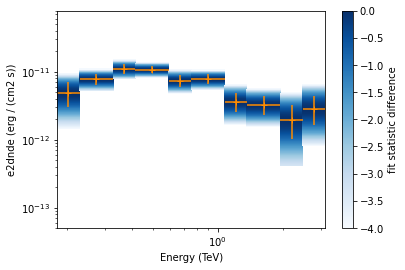

In [29]:
fig = plt.figure()

ax = analysis.flux_points.data.plot(
    energy_power=2, flux_unit="erg-1 cm-2 s-1", color="darkorange"
)
likelihood = analysis.flux_points.data.to_sed_type("e2dnde").plot_ts_profiles(ax=ax)
ax.set_ylim(5e-14, 8e-11);


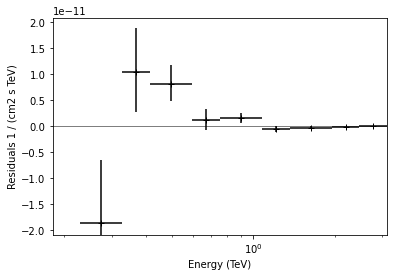

In [30]:
analysis.flux_points.plot_residuals();

In [31]:
print('Flux points\n')
print('Unit: TeV^-1 cm^-2 s^-1')
print('')
print('Energy [TeV]  |      Flux      |    Flux low    |    Flux high   |  Significance')
flux    = analysis.flux_points.data.table['dnde']
fluxerr = analysis.flux_points.data.table['dnde_err']
fluxul  = analysis.flux_points.data.table['dnde_ul']
sqrtts  = analysis.flux_points.data.table['sqrt_ts']
isul    = sqrtts < 2
for e,f,fl,fh,lim,ul,s in zip(analysis.flux_points.data.table['e_ref'], flux, flux-fluxerr, flux+fluxerr, fluxul, isul, sqrtts):
    if ul:
        print('{:^14.3f}|{:^16s}|{:16s}|{:16s}|{:^16.2f}'.format(e, '< {:.4g}'.format(lim), ' ', ' ', s))
    else:
        print('{:^14.3f}|{:^16.4g}|{:^16.4g}|{:^16.4g}|{:^16.2f}'.format(e, f, f-fl, f+fh, s))

Flux points

Unit: TeV^-1 cm^-2 s^-1

Energy [TeV]  |      Flux      |    Flux low    |    Flux high   |  Significance
    0.204     |   7.334e-11    |   2.926e-11    |   1.759e-10    |      3.22      
    0.275     |   6.482e-11    |   1.178e-11    |   1.414e-10    |      8.08      
    0.370     |   5.046e-11    |   8.138e-12    |   1.091e-10    |     10.76      
    0.497     |    2.73e-11    |    3.49e-12    |   5.809e-11    |     14.66      
    0.669     |   1.035e-11    |    2.04e-12    |   2.274e-11    |      9.72      
    0.901     |   5.998e-12    |   9.888e-13    |   1.299e-11    |     12.45      
    1.213     |   1.532e-12    |    5.03e-13    |   3.568e-12    |      6.06      
    1.632     |    7.59e-13    |   2.372e-13    |   1.755e-12    |      6.29      
    2.197     |   2.537e-13    |   1.452e-13    |   6.526e-13    |      3.20      
    2.786     |   2.277e-13    |   1.132e-13    |   5.685e-13    |      4.56      


In [32]:
analysis.flux_points.data.table_formatted

e_ref,e_min,e_max,ref_dnde,ref_flux,ref_eflux,ref_e2dnde,norm,stat,success,norm_err,norm_errp,norm_errn,norm_ul,sqrt_ts,ts,null_value,norm_scan [11],stat_scan [11],counts [8],dnde,dnde_ul,dnde_err,dnde_errp,dnde_errn,is_ul
TeV,TeV,TeV,1 / (cm2 s TeV),1 / (cm2 s),TeV / (cm2 s),TeV / (cm2 s),,,,,,,,,,,,,,1 / (cm2 s TeV),1 / (cm2 s TeV),1 / (cm2 s TeV),1 / (cm2 s TeV),1 / (cm2 s TeV),
float64,float64,float64,float64,float64,float64,float64,float64,float64,bool,float64,float64,float64,float64,float64,float64,int64,float64,float64,int64,float64,float64,float64,float64,float64,bool
0.204,0.181,0.230,1.743e-10,8.493e-12,1.725e-12,7.253e-12,0.421,25658.605,True,0.168,0.179,0.156,0.804,3.216,10.343,0,0.200 .. 5.000,25660.743 .. 25842.932,0 .. 315,7.334e-11,1.401e-10,2.926e-11,3.127e-11,2.727e-11,False
0.275,0.230,0.328,8.349e-11,8.267e-12,2.247e-12,6.295e-12,0.776,58268.792,True,0.141,0.147,0.135,1.082,8.085,65.362,0,0.200 .. 5.000,58295.254 .. 58562.907,0 .. 488,6.482e-11,9.034e-11,1.178e-11,1.227e-11,1.130e-11,False
0.370,0.328,0.416,4.000e-11,3.531e-12,1.299e-12,5.463e-12,1.261,40872.690,True,0.203,0.212,0.195,1.704,10.756,115.681,0,0.200 .. 5.000,40929.360 .. 41013.848,198 .. 224,5.046e-11,6.816e-11,8.138e-12,8.492e-12,7.784e-12,False
0.497,0.416,0.594,1.916e-11,3.437e-12,1.692e-12,4.741e-12,1.425,51829.688,True,0.182,0.189,0.175,1.816,14.655,214.773,0,0.200 .. 5.000,51933.542 .. 52000.129,689 .. 177,2.730e-11,3.480e-11,3.490e-12,3.628e-12,3.355e-12,False
0.669,0.594,0.754,9.181e-12,1.468e-12,9.783e-13,4.114e-12,1.127,24298.192,True,0.222,0.237,0.208,1.625,9.724,94.558,0,0.200 .. 5.000,24336.100 .. 24409.515,354 .. 77,1.035e-11,1.492e-11,2.040e-12,2.175e-12,1.912e-12,False
0.901,0.754,1.077,4.398e-12,1.429e-12,1.274e-12,3.571e-12,1.364,24818.240,True,0.225,0.237,0.214,1.859,12.453,155.080,0,0.200 .. 5.000,24882.814 .. 24928.096,394 .. 80,5.998e-12,8.175e-12,9.888e-13,1.041e-12,9.391e-13,False
1.213,1.077,1.366,2.107e-12,6.104e-13,7.368e-13,3.099e-12,0.727,11022.361,True,0.239,0.262,0.217,1.299,6.062,36.743,0,0.200 .. 5.000,11031.577 .. 11105.461,190 .. 32,1.532e-12,2.738e-12,5.030e-13,5.516e-13,4.567e-13,False
1.632,1.366,1.951,1.010e-12,5.942e-13,9.599e-13,2.689e-12,0.752,11132.807,True,0.235,0.256,0.214,1.309,6.294,39.614,0,0.200 .. 5.000,11143.381 .. 11220.274,182 .. 21,7.590e-13,1.322e-12,2.372e-13,2.588e-13,2.162e-13,False


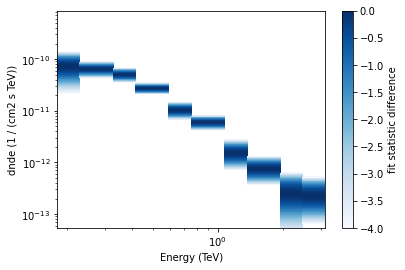

In [33]:
analysis.flux_points.data.plot_ts_profiles();

In [34]:
analysis.flux_points.data.write('../flux_and_fit_results/night1_3d_flux_points_v17_joint_high_level.ecsv',
                  include_names=['e_ref', 'e_min', 'e_max',
                                 'dnde', 'dnde_err', 'dnde_errp', 'dnde_errn', 'dnde_ul',
                                 'is_ul', 'sqrt_ts'],
                  overwrite=True)


analysis.fit_result.parameters.to_table().write('../flux_and_fit_results/night1_3d_fit17_high_leveljoint.csv', overwrite=True)
